# CO2 source: CarbonTracker model output, global, 2000-2017
# CO2 analysis method: NOAA

In [55]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions 

In [56]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [57]:
def decimalDate_datetime (datetime):
    """ Convert a date to a fractional year. """
    
    return datetime.dt.year + datetime.dt.dayofyear / [366 if x else 365 for x in datetime.dt.is_leap_year]

In [58]:
def grid_area (resolution=0.5):
    """Calculate the area of each grid cell for a user-provided
    grid cell resolution. Area is in square meters, but resolution
    is given in decimal degrees."""
    # Calculations needs to be in radians
    lats = np.deg2rad(np.arange(-90,90+resolution, resolution))
    r_sq = 6371000**2
    n_lats = int(360./resolution) 
    area = r_sq*np.ones(n_lats)[:, None]*np.deg2rad(resolution)*(
                np.sin(lats[1:]) - np.sin(lats[:-1]))
    return area.T

# Set path and date time

In [59]:
# set path of input and output
IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_model\\"

# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

# Calculate zonal and global co2 average over each 30 degree latitudinal band

In [45]:
df_co2_raw = pd.read_csv(IN_PATH + "outputglobal\\"+ "CT2018_raw_co2_2000_2017_monthly_fullglobal_level1.csv")
df_co2_cal = pd.read_csv(IN_PATH + "outputglobal\\"+ "CT2018_cal_co2_2000_2017_monthly_fullglobal_level1.csv")


zonal_deg = 30
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,4:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

global_weight = global_weight.set_axis(df_zonal_raw.index)
NH_weight = NH_weight.set_axis(df_zonal_raw.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw.index[3:])

# raw global weighted average
global_co2_raw = df_zonal_raw.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculated global weighted average
global_co2_cal = df_zonal_cal.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d')
co2_monthly = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal],axis=1)
co2_monthly.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal"]
co2_monthly["year"] = datetime.dt.year.tolist()
co2_annual = co2_monthly.groupby(["year"]).mean().T
co2_annual.to_csv(OUT_PATH +"df_annual_global_NH_SH_ctracker_model_global.csv", header=True,index=True, na_rep= "NaN")
co2_annual

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_raw,370.399356,371.904049,373.950873,376.553860,378.387281,380.545960,382.667621,384.417039,386.413258,387.947879,390.301285,392.017201,394.250403,397.078880,399.117097,401.200400,404.397679,406.945869
NH_raw,371.965223,373.763107,375.696793,378.529408,380.344855,382.510784,384.946772,386.416101,388.578505,390.105592,392.691989,394.560149,396.702690,399.429942,401.544524,403.529911,406.857533,409.673970
SH_raw,368.833488,370.044990,372.204953,374.578313,376.429707,378.581136,380.388469,382.417977,384.248012,385.790165,387.910581,389.474252,391.798116,394.727818,396.689671,398.870889,401.937826,404.217768
global_cal,370.403211,371.907365,373.950598,376.553040,378.393016,380.541201,382.667763,384.418695,386.411459,387.952617,390.298919,392.013161,394.255231,397.077159,399.121193,401.200389,404.392696,406.944326
NH_cal,371.976829,373.770221,375.692735,378.529802,380.353343,382.502667,384.945798,386.423345,388.573622,390.108963,392.692867,394.551694,396.715090,399.427358,401.547946,403.533389,406.851926,409.666981
SH_cal,368.829592,370.044508,372.208461,374.576278,376.432690,378.579735,380.389728,382.414045,384.249296,385.796272,387.904972,389.474629,391.795371,394.726959,396.694440,398.867389,401.933466,404.221672


# Plot global, NH and SH area-weighted average CO2 concentration  

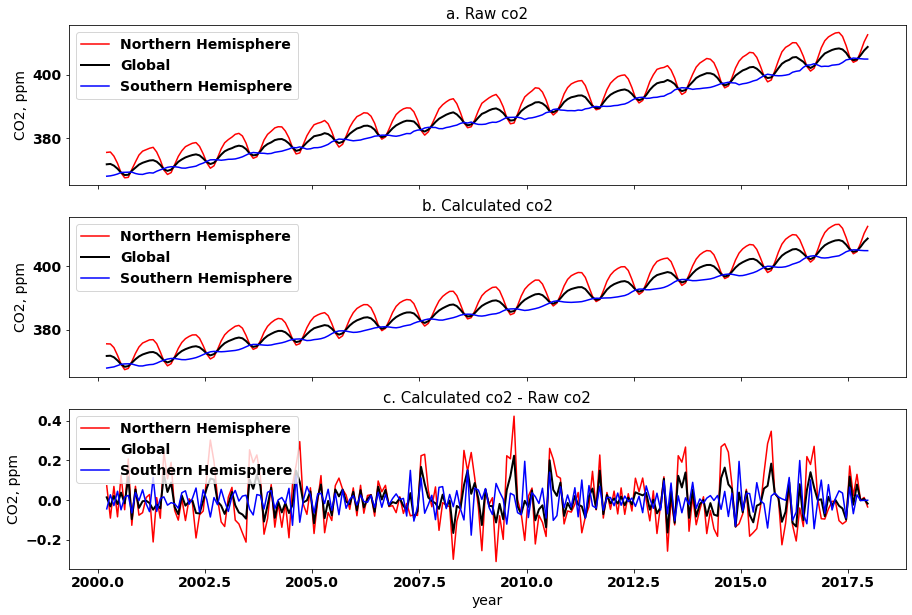

In [46]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d'))
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,NH_co2_raw, 'r', label = "Northern Hemisphere")
ax1.plot(x_decimalyear,global_co2_raw, 'k', label = "Global", lw=2)
ax1.plot(x_decimalyear,SH_co2_raw,'b', label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw co2",fontsize=15)

ax2.plot(x_decimalyear,NH_co2_cal, 'r', label = "Northern Hemisphere")
ax2.plot(x_decimalyear,global_co2_cal, 'k', label = "Global", lw=2)
ax2.plot(x_decimalyear,SH_co2_cal,'b', label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated co2",fontsize=15)

ax3.plot(x_decimalyear,NH_co2_cal - NH_co2_raw, 'r', label = "Northern Hemisphere")
ax3.plot(x_decimalyear,global_co2_cal - global_co2_raw, 'k', label = "Global", lw=2)
ax3.plot(x_decimalyear,SH_co2_cal - SH_co2_raw,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated co2 - Raw co2",fontsize=15);

# Plot co2 zonal map 

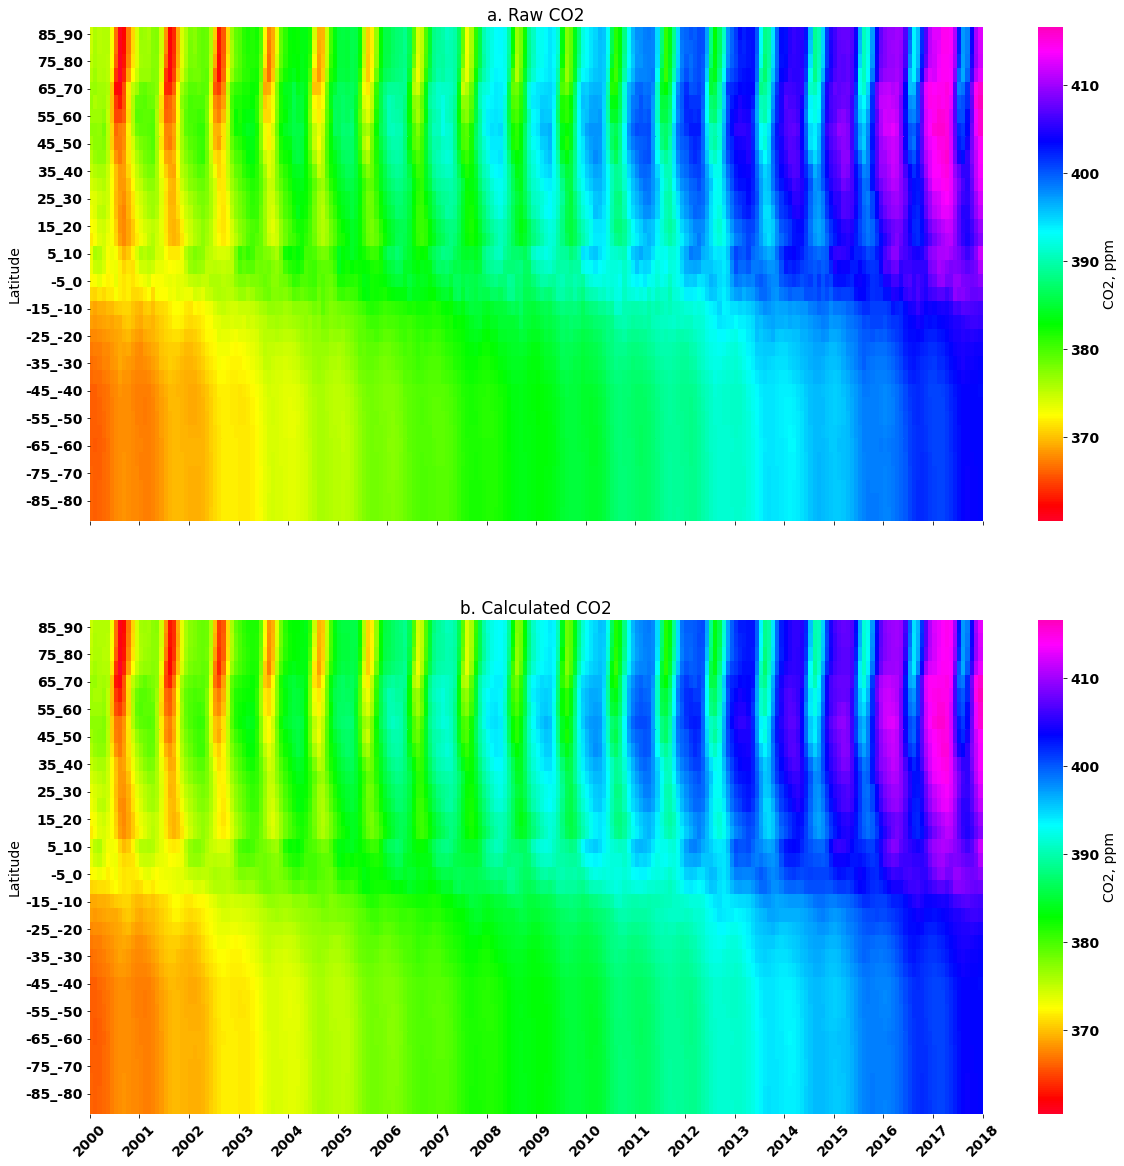

In [60]:
# Arrange dataframe for plot
df_co2_raw = pd.read_csv(IN_PATH + "outputglobal\\"+ "CT2018_raw_co2_2000_2017_monthly_fullglobal_level1.csv")
df_co2_cal = pd.read_csv(IN_PATH + "outputglobal\\"+ "CT2018_cal_co2_2000_2017_monthly_fullglobal_level1.csv")


zonal_deg = 5

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,2:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,2:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_raw.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

cmax = max(df_zonal_cal.max().max(), df_zonal_raw.max().max())
cmin = max(df_zonal_cal.min().min(), df_zonal_raw.min().min())

# sns.set(font_scale=1.4)

fig,axis = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=[20,20])
(ax1,ax2) = axis
sns.heatmap(df_zonal_raw, cmap=plt.get_cmap("gist_rainbow"), ax=ax1, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax1.set_ylabel("Latitude")
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels,rotation=45)
ax1.set_title("a. Raw CO2")

sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow"), ax=ax2, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax2.set_ylabel("Latitude")
ax2.set_xticks(xticks) 
ax2.set_xticklabels(xticklabels,rotation=45)
ax2.set_title("b. Calculated CO2");

# Calculate zonal and global CO2 growth rate average over each 30 degree latitudinal band

In [51]:
df_co2rate_cal = pd.read_csv(IN_PATH + "outputglobal\\" + "CT2018_cal_co2rate_2000_2017_monthly_fullglobal_level1.csv")

zonal_deg = 30
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_cal = pd.DataFrame() 
for i in lat_range:
    lat_id = (i < df_co2rate_cal.lat) & (df_co2rate_cal.lat<= i+zonal_deg)
    temp_cal = df_co2rate_cal.loc[lat_id,:]
    
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,2:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

global_weight = global_weight.set_axis(df_zonal_cal.index)
NH_weight = NH_weight.set_axis(df_zonal_cal.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_cal.index[3:])

# calculated global weighted average
global_co2rate_cal = df_zonal_cal.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate_cal = df_zonal_cal.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate_cal = df_zonal_cal.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = df_datetime.date
co2rate_annual = pd.concat([global_co2rate_cal,NH_co2rate_cal,SH_co2rate_cal],axis=1)
co2rate_annual.columns = ["global_co2rate_cal","NH_co2rate_cal","SH_co2rate_cal"]
co2rate_annual["year"] = datetime.dt.year.tolist()
co2rate_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2rate_cal,1.374918,1.611847,2.517418,2.349386,1.631286,2.518829,1.656728,2.111196,1.549339,1.877501,2.385148,1.523474,2.824925,2.533298,1.735893,2.715875,3.170686,2.116071
NH_co2rate_cal,1.542164,1.398298,2.589233,2.566278,1.541133,2.669034,1.791035,1.916283,1.692665,1.937829,2.656813,1.535273,2.722263,2.470861,1.802171,2.606574,3.532556,2.073870
SH_co2rate_cal,1.207673,1.825395,2.445604,2.132493,1.721439,2.368624,1.522421,2.306109,1.406013,1.817173,2.113482,1.511675,2.927587,2.595736,1.669616,2.825176,2.808817,2.158273


# Plot global, NH and SH area-weighted average CO2 growth rate

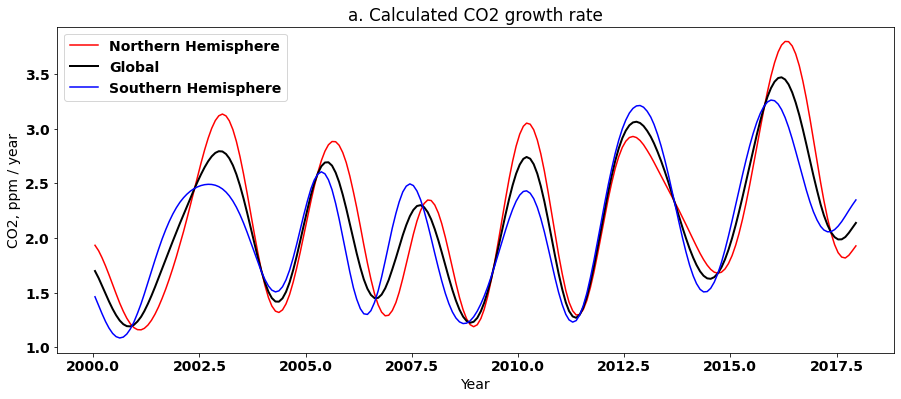

In [63]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d'))

fig = plt.figure( figsize = (15,6))
ax = plt.axes()

ax.plot(x_decimalyear,NH_co2rate_cal, 'r', label = "Northern Hemisphere")
ax.plot(x_decimalyear,global_co2rate_cal, 'k', label = "Global", lw=2)
ax.plot(x_decimalyear,SH_co2rate_cal,'b', label = "Southern Hemisphere")
ax.set_xlabel("Year")
ax.set_ylabel("CO2, ppm / year")
ax.legend()
ax.set_title("a. Calculated CO2 growth rate");


# Plot CO2 growth rate  zonal map

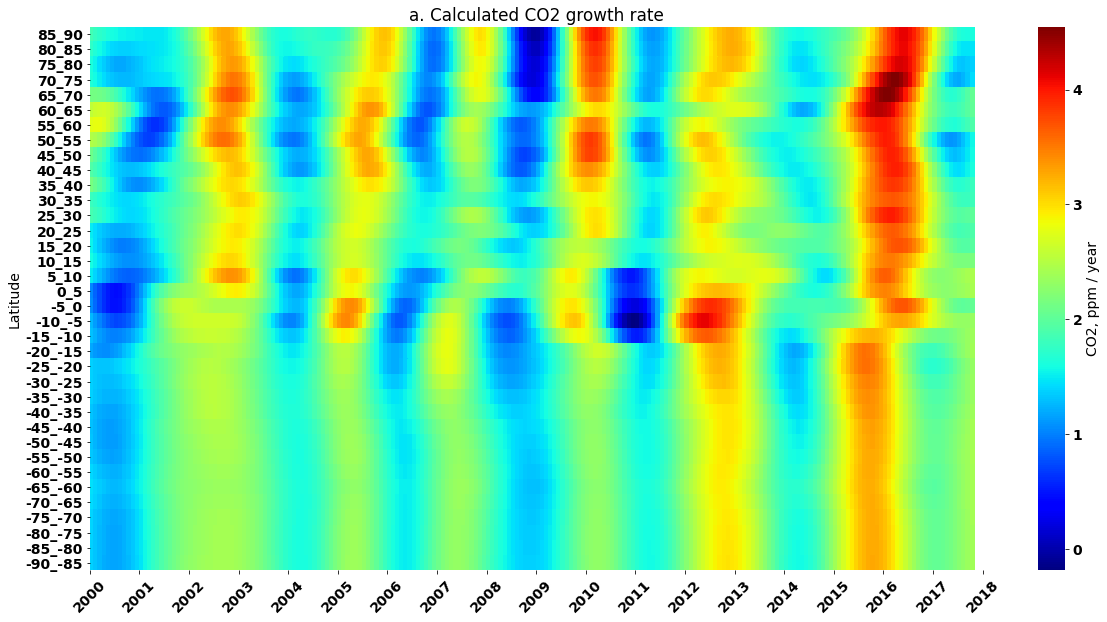

In [64]:
# Arrange dataframe for plot
df_co2rate_cal = pd.read_csv(IN_PATH + "outputglobal\\" + "CT2018_cal_co2rate_2000_2017_monthly_fullglobal_level1.csv")

zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2rate_cal.lat) & (df_co2rate_cal.lat<= i+zonal_deg)
    temp_cal = df_co2rate_cal.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("jet"),  cbar_kws={'label': 'CO2, ppm / year'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 growth rate");


#BIR statation at (8.3, 58)